# Recreating the K2-18b Paper's Figure (but with G Star)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from astropy import constants
from photochem.utils import zahnle_rx_and_thermo_files
from photochem.extensions import gasgiants # Import the gasgiant extensions

import json
from astroquery.mast import Observations
from photochem.utils import stars

import star_spectrum
import pickle

## Use Muscles to find flux of host star for photochem

In [2]:
Observations.query_region("K2-18")

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str11,str5,str31,str13,str10,str17,str16,str21,str40,str78,float64,float64,str10,str20,int64,float64,float64,float64,float64,float64,str89,float64,str55,str10,int64,str25174,str137,str137,str16,bool,float64,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0045-4-4,173.32309487189954,10.123660977574168,image,"Ricker, George",3,59525.00295460648,59550.12330810185,475.199789,600.0,1000.0,--,59575.0,N/A,--,45,POLYGON 176.363708 2.182988 165.42042 6.934329 170.418384 18.143905 181.088068 13.022403 176.363708 2.182988,--,--,PUBLIC,False,nan,71308567,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0046-3-4,176.96751704139461,8.75939874156979,image,"Ricker, George",3,59551.06051445602,59578.20208652778,475.199787,600.0,1000.0,--,59603.0,N/A,--,46,POLYGON 180.044679 0.831165 169.096058 5.548241 174.044906 16.770242 184.682476 11.705753 180.044679 0.831165,--,--,PUBLIC,False,nan,71644385,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0072-4-4,176.3290073220256,7.70126445589495,image,"Ricker, George",3,60259.673948275464,60285.08137564815,158.399928,600.0,1000.0,--,60297.0,N/A,--,72,POLYGON 179.487986 -0.189 168.509871 4.416232 173.335287 15.680354 183.980695 10.737843 179.487986 -0.189,--,--,PUBLIC,False,nan,199193129,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,388804061,--,tess2018235142541-s0002-s0072-0000000388804061,172.56049010363,7.58840478280286,timeseries,"Ricker, George",3,59524.997376666666,60285.07617158565,120.0,600.0,1000.0,--,60339.0,G06058_G06195,--,72,CIRCLE 172.5604901 7.58840478 0.00138889,--,mast:TESS/product/tess2018235142541-s0002-s0072-0000000388804061-00829_dvt.fits,PUBLIC,False,nan,208737524,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,388804061,--,tess2021233042500-s0042-s0046-0000000388804061,172.56049010363,7.58840478280286,timeseries,"Ricker, George",3,59524.997376666666,59578.202453391204,120.0,600.0,1000.0,--,59641.0,G04205_G04098_G04242_G04039_G04191,--,46,CIRCLE 172.5604901 7.58840478 0.00138889,--,mast:TESS/product/tess2021233042500-s0042-s0046-0000000388804061-00550_dvt.fits,PUBLIC,False,nan,71746805,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,388804061,--,tess2021310001228-s0045-0000000388804061-0216-s,172.56049010363,7.58840478280286,timeseries,"Ricker, George",3,59525.7779928588,59550.12329581018,120.0,600.0,1000.0,--,59575.0,G04205_G04098_G04242_G04039_G04191,--,45,CIRCLE 172.5604901 7.58840478 0.00138889,--,mast:TESS/product/tess2021310001228-s0045-0000000388804061-0216-s_lc.fits,PUBLIC,False,nan,71247814,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,388804061,--,tess2021336043614-s0046-0000000388804061-0217-s,172.56049010363,7.58840478280286,timeseries,"Ricker, George",3,59551.06365431713,59578.202453391204,120.0,600.0,1000.0,--,59603.0,G04205_G04098_G04242_G04039_G04191,--,46,CIRCLE 172.5604901 7.58840478 0.00138889,--,mast:TESS/product/tess2021336043614-s0046-0000000388804061-0217-s_lc.fits,PUBLIC,False,nan,71499253,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,388804061,--,tess2023315124025-s0072-0000000388804061-0267-a_fast,172.56049010363,7.58840478280286,timeseries,"Ricker, George",3,60259.67933263889,60285.08265369213,20.0,600.0,1000.0,--,60297.0,G06058_G06195,--,72,CIRCLE 172.5604901 7.58840478 0.00138889,--,mast:TESS/product/tess2023315124025-s0072-0000000388804061-0267-a_fast-lc.fits,PUBLIC,False,nan,198797867,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,388804061,--,tess2023315124025-s0072-0000000388804061-0267-s,172.56049010363,7.58840478280286,timeseries,"Ricker, George",3,60259.67933263889,60285.06922646991,120.0,600.0,1000.0,--,602

### Create Stellar Flux File for GJ176 from MUSCLE Database

#### Find the spectrum of interest & its file location

In [3]:
# Look for the spectrum of interest
star_name = "GJ176"
all_obs = Observations.query_criteria(
    provenance_name="muscles",
    objectname=star_name
    )

data_products = Observations.get_product_list(all_obs)

 # Look through the results for the spectrum we want.
tmp = None
for i,a in enumerate(data_products['productFilename']):
    if 'adapt-const-res-sed' in a and '_'+star_name.lower()+'_' in a:
        tmp = data_products[i]
        break

print(data_products.keys())
print(tmp['dataURI'])

['obsID', 'obs_collection', 'dataproduct_type', 'obs_id', 'description', 'type', 'dataURI', 'productType', 'productGroupDescription', 'productSubGroupDescription', 'productDocumentationURL', 'project', 'prvversion', 'proposal_id', 'productFilename', 'size', 'parent_obsid', 'dataRights', 'calib_level', 'filters']
mast:HLSP/muscles/v22/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits


#### Manually Download from the MUSCLE website

In [4]:
from astropy.io import fits
file = '/Users/epawelka/Documents/NASA_Ames_ProjS25/AmesProjS25Work/MAST_2025-08-19T2217/HLSP/hlsp_muscles_gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits'
data = fits.getdata(file)

In [5]:
data = fits.getdata(file)

# Get the spectrum
wv = data['WAVELENGTH']/10 # convert from Angstroms to nm
# (erg/cm2/s/Ang)*(1 W/1e7 erg)*(1e3 mW/1 W)*(1e4 cm^2/1 m^2)*(10 Ang/1 nm) = mW/m^2/nm
F = data['FLUX']*(1/1e7)*(1e3/1)*(1e4/1)*(10/1) # convert from erg/cm2/s/Ang to mW/m^2/nm

# Remove duplicated wavelengths
wv, inds = np.unique(wv, return_index=True)
F = F[inds]

In [6]:
# Find the stellar flux file of GJ176
file_muscle_path = star_spectrum.find_star_file(star_name='GJ176', provenance_name='muscles')
print(file_muscle_path)
file = '/Users/epawelka/Documents/NASA_Ames_ProjS25/AmesProjS25Work/MAST_2025-08-19T2217/HLSP/hlsp_muscles_gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits'
wv, f = star_spectrum.muscles_spectrum(star_name='GJ176', file=file, Teq=278, outputfile='GJ176_spectrum_278K.txt')
print(f)

mast:HLSP/muscles/v22/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits
[9.80778853e-01 3.70529775e+00 1.68200996e+00 ... 2.48645330e-04
 1.72115216e-04 7.47971836e-05]


### Create Stellar Flux File for the Sun from MUSCLE Database

In [7]:
wv, F = star_spectrum.solar_spectrum(outputfile='Sun_Teq278', Teq=278)

#### utils.stars has some helpful functions for determining energy in the system & Teq of the planet
Also, you can add a ? to the end of any defined function to learn more about it!

In [8]:
print(stars.energy_in_spectrum(wv, F)) # The total energy in the spectrum
print(stars.equilibrium_temperature(1361, 0)) # Solves for the equilibrium temperature given total flux of the planet
print(stars.equilibrium_temperature_inverse(258, 0)) # Solves for the total flux given the equilibrium temperature. 
stars.muscles_spectrum?

1354.7242645793965
278.3213993561373
1004.9641091259228


Signature:
stars.muscles_spectrum(
    star_name,
    outputfile=None,
    Teq=None,
    stellar_flux=None,
    needed_resolution=True,
)
Docstring:
Downloads a MUSCLES spectrum (https://archive.stsci.edu/prepds/muscles/), 
then adds on a blackbody extending the star to 100 microns, and finally 
rescale the spectrum so that it has a total bolometric insolation at a planet 
consistent with `Teq` or `stellar_flux`. Finally, the spectrum can be saved to 
`outputfile` in photochem format.

Parameters
----------
star_name : str
    Name of the MUSCLES star
outputfile : str, optional
    If not None, then this is the output filename, be default None.
Teq : float, optional
    Zero-albedo equilibrium temperature of the planet (K), by default None
stellar_flux : float, optional
    Stellar flux at the planet (W/m^2), by default None
needed_resolution : bool, optional
    If True, then the spectrum is rebinned to a resolution 4x higher than
    What is used by the photochemical and climate mode

## Defined Functions for PT Profile & Photochem Model

In [9]:
def PICASO_PT_Planet(mh=None, ctoO=None, ck_db=None, tint=None, grav=None, opacity_ck=None, T_star=None, logg=None, metal=None, r_star=None, semi_major=None, nlevel=91, Teq=None, nofczns=1, nstr_upper=None, rfacv=0.5, outputfile=f'MDwarf_{None}'):

    # Starting Up the Run
    cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
    cl_run.effective_temp(tint) # input effective temperature
    cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, 
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

    # Initial T(P) Guess
    nstr_deep = nlevel -2
    nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones
    pt = cl_run.guillot_pt(Teq, nlevel=nlevel, T_int = tint, p_bottom=3, p_top=-6)
    temp_guess = pt['temperature'].values 
    pressure = pt['pressure'].values

    # Initial Convective Zone Guess
    cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, 
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)
    
    out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)
    base_case = jdi.pd.read_csv(jdi.HJ_pt(), delim_whitespace=True)

    # Saves out and base_case to python file to be re-loaded.
    with open(f'out_{outputfile}.pkl', 'wb') as f:
        pickle.dump(out, f)
    with open(f'basecase_{outputfile}.pkl', 'wb') as f:
        pickle.dump(base_case, f)

    return out, base_case

In [10]:
def Photochem_Gas_Giant(atoms_names, stellar_flux_file, planet_mass, planet_radius, solar_zenith_angle, PT_list, metallicity, CtoO, Kzz_fac):

    #Generate reaction & thermodynamic files for gas giants
    zahnle_rx_and_thermo_files(
    atoms_names=atoms_names,
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True # For gas giants, we should always leave out reaction particles.
    )

    # Initialize ExoAtmosphereGasGiant
    # Assigns 
    pc = gasgiants.EvoAtmosphereGasGiant(
        mechanism_file='photochem_rxns.yaml',
        stellar_flux_file=stellar_flux_file,
        planet_mass=planet_mass,
        planet_radius=planet_radius,
        solar_zenith_angle=solar_zenith_angle,
        thermo_file='photochem_thermo.yaml'
    )
    
    pc.gdat.verbose = True # printing

    # Define the host star composition
    molfracs_atoms_sun = np.ones(len(pc.gdat.gas.atoms_names))*1e-10 # This is for the Sun
    comp = {
        'H' : 9.21e-01,
        'N' : 6.23e-05,
        'O' : 4.51e-04,
        'C' : 2.48e-04,
        'S' : 1.21e-05,
        'He' : 7.84e-02
    }

    tot = sum(comp.values())
    for key in comp:
        comp[key] /= tot
    for i,atom in enumerate(pc.gdat.gas.atoms_names):
        molfracs_atoms_sun[i] = comp[atom]
    
    pc.gdat.gas.molfracs_atoms_sun = molfracs_atoms_sun

    # Assume a default radius for particles 1e-5cm was default, so we increased the size but think of these in microns
    particle_radius = pc.var.particle_radius
    particle_radius[:,:] = 1e-3 #cm or 10 microns
    pc.var.particle_radius = particle_radius

    # Define Kzz & P-T Profile
    P = np.flip(PT_list[0]) * (10**6) # Convert from bars to dynes/cm^2
    T = np.flip(PT_list[1])

    # Assumed Kzz (cm^2/s) in Tsai et al. (2023)
    Kzz_zero_grid = np.ones(P.shape[0])
    Kzz = Kzz_zero_grid*Kzz_fac

    # Initialize the PT based on chemical equilibrium 
    pc.gdat.BOA_pressure_factor = 3
    pc.initialize_to_climate_equilibrium_PT(P, T, Kzz, metallicity, CtoO)

    # Integrate to steady state
    pc.find_steady_state()
    sol = pc.return_atmosphere()
    soleq = pc.return_atmosphere(equilibrium=True)

    return sol, soleq, pc
    

### Use PICASO to model PT profile of K2-18b based on K2-18 M-dwarf

#### Planet & Star Properties Calculated 


In [11]:
# K2-18b Gravity:
K218b_grav = (const.G * (8.63*5.972e+24*u.kg)) / ((2.61*6.371e+6*u.m)**2)
K218b_grav.value

12.440564681716218

In [12]:
np.log10(K218b_grav.value*100)

3.0948400935853124

In [13]:
stars.equilibrium_temperature(1*1361, 0) #Stellar Insolation of 1 according to Benneke et. al. 2019 & Bond Albedo of 0

278.3213993561373

In [14]:
# Planet Parameters

#1 ck tables from roxana
mh = '+2.0'#'+1.0' #log metallicity, 10xSolar
ctoO = '1.0'#'1.0' # CtoO ratio, Solar C/O
ck_db = f'/Users/epawelka/Documents/NASA_Ames_ProjS25/AmesProjS25Work/picaso_v4/climate/sonora_2020_feh+200_co_100.data.196'
tint= 60 # Intrinsic Temperature of your Planet in K, Wogan et. al. 2024
grav = K218b_grav.value # Gravity of your Planet in m/s/s based on Mass and Radius of K2-18b observed
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db, method='preweighted') # grab your opacities


# Star Parameters
T_star = 3500 # K, star effective temperature, the min value is 3500K 
logg = 4.858 #logg , cgs
metal = 0.12 # metallicity of star
r_star = 0.4445 # solar radius
semi_major = 0.159 # star planet distance, AU

cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation 
cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature
cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, 
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

# Initial guesses for T(P)
nlevel = 91 # number of plane-parallel levels in your code
#Lets set the max and min at 1e-4 bars and 500 bars
Teq = 278 # planet equilibrium temperature 

# Initial guesses for Convective Zone
nofczns = 1 # number of convective zones initially. Let's not play with this for now.
nstr_upper = 85 # top most level of guessed convective zone
# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a mini-Neptune so let's keep this as is

#### Example of Running T(P) Profile (only run if you don't have the corresponding output file)

In [15]:
out, base_case = PICASO_PT_Planet(mh=mh, 
                 ctoO=ctoO, 
                 ck_db=ck_db, 
                 tint=tint, 
                 grav=grav, 
                 opacity_ck=opacity_ck, 
                 T_star=T_star, 
                 logg=logg, 
                 metal=metal, 
                 r_star=r_star, 
                 semi_major=semi_major, 
                 nlevel=nlevel, 
                 Teq=Teq, 
                 nofczns=nofczns, 
                 nstr_upper=nstr_upper,  
                 rfacv=rfacv, 
                 outputfile=f'MDwarf_{T_star}_initP3bar')

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Iteration number  0 , min , max temp  239.58569766271233 822.4072144622232 , flux balance  -37.55006971611411
Iteration number  1 , min , max temp  239.6405209062712 832.3915161417774 , flux balance  -37.54017618332123
Iteration number  2 , min , max temp  239.69603006049513 842.2913475126447 , flux balance  -37.529847642624176
Iteration number  3 , min , max temp  239.75324807327232 852.1150144680993 , flux balance  -37.519072552467755
Iteration number  4 , min , max temp  239.81244260671957 861.8595219857286 , flux balance  -37.50783900082026
Iteration number  5 , min , max temp  239.87384431488732 871.5380864018799 , flux balance  -37.49613470220438
Iteration number  6 , min , max temp  239.93712735383707 881.1518643830995 , flux balance  -37.48394699259848
Iteration number  7 , min , max temp  240.0029134059827 890.7091294756508 , flux balance  -37.47126282244026
Iteration

SystemError: CPUDispatcher(<function t_start at 0x174f277e0>) returned a result with an exception set

#### Load the results

In [16]:
with open('out_MDwarf_3500_initp3bar.pkl', 'rb') as file:
    out_reopened = pickle.load(file)

out_reopened

{'pressure': array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
        2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
        6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
        1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
        3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
        1.00000000e-04, 1.25892541e-04, 1.58489319e-04, 1.99526231e-04,
        2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
        6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
        1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
        3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
        1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
        2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
        6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
        1.58489319e-01, 1.99526231e-01, 2.51188643e-

In [17]:
with open('out_MDwarf_3500_initp3bar.pkl','rb') as file:
    base_case_reopened = pickle.load(file)

base_case_reopened

{'pressure': array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
        2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
        6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
        1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
        3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
        1.00000000e-04, 1.25892541e-04, 1.58489319e-04, 1.99526231e-04,
        2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
        6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
        1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
        3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
        1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
        2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
        6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
        1.58489319e-01, 1.99526231e-01, 2.51188643e-

#### Plot the PT Profile from PICASO

Text(0.5, 1.0, 'T$_{\\rm eff}$= 254 K, log(g)=4.8')

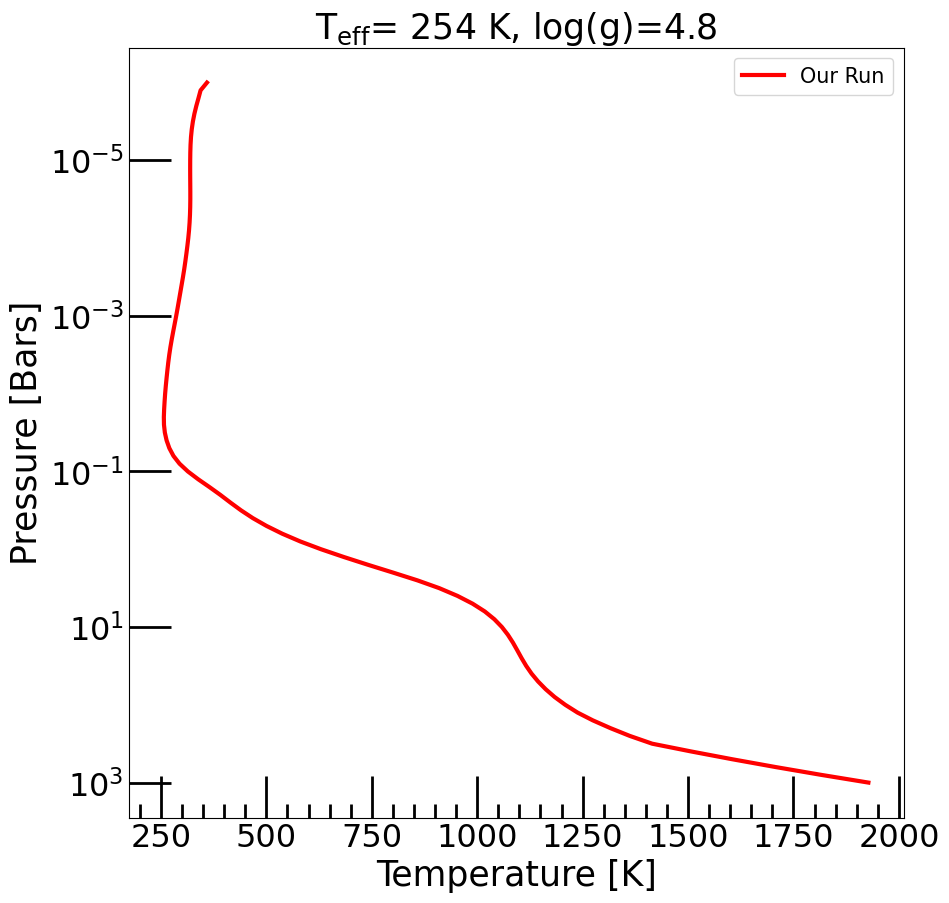

In [18]:
# Plot the PT Profile from PICASO
plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.gca().invert_yaxis()
#plt.ylim(500,1e-4)
#plt.xlim(250,1750)

plt.semilogy(out_reopened['temperature'],out_reopened['pressure'],color="r",linewidth=3,label="Our Run")

#plt.semilogy(base_case['temperature'],base_case['pressure'],color="k",linestyle="--",linewidth=3,label="WASP-39 b ERS Run")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 254 K, log(g)=4.8",fontsize=25)


### Use Photochem to model Chemical Molecular Abundances of K2-18b on K2-18 M-Dwarf 

#### Planet & Star Properties Defined

In [19]:
# With K218b around our Sun!

class K218b:
    planet_radius = 0.2328 # Jupiter radii
    planet_mass = 0.0272 # Jupiter masses
    planet_Teq = 278 # Equilibrium temp (K)
    stellar_radius = 0.4445 # Solar radii
    stellar_Teff = 3500 # K
    stellar_metal = 0.12 # log10(metallicity), IDK what to switch here
    stellar_logg = 4.858 # log10(gravity), in cgs units

# Defines reaction & thermodynamic files
atoms_names=['H', 'He', 'N', 'O', 'C'] # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl), remove Sulpher for faster convergence

# Defines planet parameters
planet_mass = K218b.planet_mass*constants.M_jup.value*1e3 # grams, which is assigns a unit to the mass in Jupiter Masses, multiplyed by 10^3?
planet_radius = K218b.planet_radius*constants.R_jup.value*1e2 # cm, again which is 100x greater in radius than WASP39b but in Jupiter Radii?
solar_zenith_angle = 60 # Used in Tsai et al. (2023)
PT_list = [out_reopened.get("pressure"), out_reopened.get("temperature")]
metallicity = 100.0 # units of solar
CtoO = 1.0 # 1x solar
Kzz = 10**7 # cm^2/s

# Defines solar parameters
stellar_flux_file = 'GJ176_spectrum_278K.txt'

# Define your pressure and temperature profile
PT_list = out_reopened['pressure'], out_reopened['temperature']
P = np.flip(PT_list[0]) * 10**6 # Convert from bars to dynes/cm^2

#### Run Photochem for Gas Giant

In [20]:
sol, soleq, pc = Photochem_Gas_Giant(atoms_names=atoms_names, 
                                 stellar_flux_file=stellar_flux_file,
                                 planet_mass=planet_mass, 
                                 planet_radius=planet_radius, 
                                 solar_zenith_angle=solar_zenith_angle, 
                                 PT_list=PT_list, 
                                 metallicity=metallicity, 
                                 CtoO=CtoO,
                                 Kzz_fac=Kzz)

nsteps = 100  longdy = 5.0e-01  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-07
nsteps = 200  longdy = 1.4e+00  max_dT = 1.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-07
nsteps = 300  longdy = 3.1e+00  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-07
nsteps = 400  longdy = 1.6e+00  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 500  longdy = 1.1e+00  max_dT = 1.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-07
nsteps = 600  longdy = 1.0e+00  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 700  longdy = 1.0e+00  max_dT = 4.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 800  longdy = 8.2e-01  max_dT = 7.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 900  longdy = 1.9e-02  max_dT = 1.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-07
nsteps = 901  longdy = 2.6e-03  max_dT = 1.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-07
nsteps = 1001  longd

#### Graph the Results of M-Dwarf

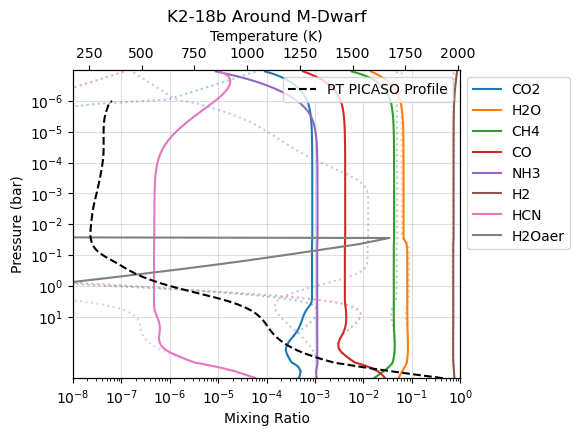

In [21]:
# Plot the Composition from Photochem
fig, ax1 = plt.subplots(1,1,figsize=[5,4])
species = ['CO2','H2O','CH4','CO','NH3','H2','HCN','H2Oaer']

for i,sp in enumerate(species):
    ax1.plot(sol[sp],sol['pressure']/1e6,label=sp, c='C'+str(i))
    ax1.plot(soleq[sp],soleq['pressure']/1e6, ls=':', c='C'+str(i), alpha=0.4)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-8,1)
ax1.set_ylim(1000,1e-7)
ax1.grid(alpha=0.4)
ax1.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
ax1.set_xlabel('Mixing Ratio')
ax1.set_ylabel('Pressure (bar)')
ax1.set_yticks(10.0**np.arange(-6,2))
#ax1.text(0.02, 1.04, 't = '+'%.2e'%pc.wrk.tn, \
#    size = 15,ha='left', va='bottom',transform=ax1.transAxes)

ax2 = ax1.twiny()
ax2.set_xlabel('Temperature (K)')
ax2.plot(np.flip(PT_list[1]), np.flip(PT_list[0]), c='black', ls='--',label='PT PICASO Profile')

plt.title('K2-18b Around M-Dwarf')

plt.legend()

# Save the plot as a PNG image
# plt.savefig('output_graph_MDwarf_K218b.png', bbox_inches='tight')

# Close the plot to free up memory (important if you're generating many plots)
# plt.close()

plt.show()

## Now repeat but for G-Star!

### Do necessary adjustment calculations to Planet and Star Parameters

In [22]:
stars.equilibrium_temperature?

Signature:       stars.equilibrium_temperature(stellar_radiation, bond_albedo)
Call signature:  stars.equilibrium_temperature(*args, **kwargs)
Type:            CPUDispatcher
String form:     CPUDispatcher(<function equilibrium_temperature at 0x3024e2160>)
File:            ~/miniforge3/envs/AmesProjS25/lib/python3.12/site-packages/photochem/utils/stars.py
Docstring:      
Equilibrium temperature of a planet.

Parameters
----------
stellar_radiation : float
    Incident energy at a planet in W/m^2
bond_albedo : float
    Bond albedo

Returns
-------
float
    The equilibrium temperature (K)
Class docstring:
Implementation of user-facing dispatcher objects (i.e. created using
the @jit decorator).
This is an abstract base class. Subclasses should define the targetdescr
class attribute.
Init docstring: 
Parameters
----------
py_func: function object to be compiled
locals: dict, optional
    Mapping of local variable names to Numba types.  Used to override
    the types deduced by the type i

In [23]:
# What is the semi-major axis that is self-consistent?
luminosity_star = (3.828*(10**26))*0.0234
T_eff_planet = 278
boltzmann_const = 5.670374419*(10**-8)
distance_m = np.sqrt(luminosity_star / (16 * np.pi * boltzmann_const * (T_eff_planet**4)))
distance_AU = distance_m / 1.496e+11
print(distance_AU)

0.1533316862832182


In [24]:
# What is the semi-major axis that is self-consistent?
luminosity_star = 3.846*(10**26)
boltzmann_const = 5.670374419*(10**-8)
T_eff_planet = 278
distance_m = np.sqrt(luminosity_star / (16 * np.pi * boltzmann_const * (T_eff_planet**4)))
distance_AU = distance_m / 1.496e+11
print(distance_AU)

1.0047144735663656


### Apply PICASO for PT Profile

In [25]:
# Planet Parameters

#1 ck tables from roxana
mh = '+2.0'#'+1.0' #log metallicity, 10xSolar
ctoO = '1.0'#'1.0' # CtoO ratio, Solar C/O
ck_db = f'/Users/epawelka/Documents/NASA_Ames_ProjS25/AmesProjS25Work/picaso_v4/climate/sonora_2020_feh+200_co_100.data.196'
tint= 60 # Intrinsic Temperature of your Planet in K, Wogan et. al. 2024
grav = K218b_grav.value # Gravity of your Planet in m/s/s based on Mass and Radius of K2-18b observed
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db, method='preweighted') # grab your opacities


# Star Parameters
T_star = 5778 # K, star effective temperature, the min value is 3500K 
logg = 4.4 #logg , cgs
metal = 0.0 # metallicity of star
r_star = 1 # solar radius
semi_major = 1 # star planet distance, AU

cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation 
cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature
cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, 
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

# Initial guesses for T(P)
nlevel = 91 # number of plane-parallel levels in your code
#Lets set the max and min at 1e-4 bars and 500 bars
Teq = 278 # planet equilibrium temperature 

# Initial guesses for Convective Zone
nofczns = 1 # number of convective zones initially. Let's not play with this for now.
nstr_upper = 85 # top most level of guessed convective zone
# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a mini-Neptune so let's keep this as is

### Another example of the code needed for the output...but just loaded output instead

In [26]:
out_Gstar, base_case_Gstar = PICASO_PT_Planet(mh=mh, 
                 ctoO=ctoO, 
                 ck_db=ck_db, 
                 tint=tint, 
                 grav=grav, 
                 opacity_ck=opacity_ck, 
                 T_star=T_star, 
                 logg=logg, 
                 metal=metal, 
                 r_star=r_star, 
                 semi_major=semi_major, 
                 nlevel=nlevel, 
                 Teq=Teq, 
                 nofczns=nofczns, 
                 nstr_upper=nstr_upper,  
                 rfacv=rfacv, 
                 outputfile=f'Sun_{T_star}_initP3bar')

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Iteration number  0 , min , max temp  239.53827412477617 819.2768645254189 , flux balance  90.48640463033776
Iteration number  1 , min , max temp  239.54842349840573 826.2576920081345 , flux balance  90.4727153663843
Iteration number  2 , min , max temp  239.5580763756615 833.2707992451868 , flux balance  90.4584574900859
Iteration number  3 , min , max temp  239.56758885944623 840.3156841600775 , flux balance  90.44361562532607
Iteration number  4 , min , max temp  239.57739468055908 847.3927306975895 , flux balance  90.42817407997242
Iteration number  5 , min , max temp  239.58719370038258 854.4938879447559 , flux balance  90.4121168382768
Iteration number  6 , min , max temp  239.59737675548874 861.6200871273282 , flux balance  90.39542755238466
Iteration number  7 , min , max temp  239.60787727154153 868.7734927715147 , flux balance  90.37808953293141
Iteration number  8 ,

In [27]:
with open('out_Sun_5778_initP3bar.pkl', 'rb') as file:
    out_reopened = pickle.load(file)

out_Gstar = out_reopened

Text(0.5, 1.0, 'T$_{\\rm eff}$= 254 K, log(g)=4.8')

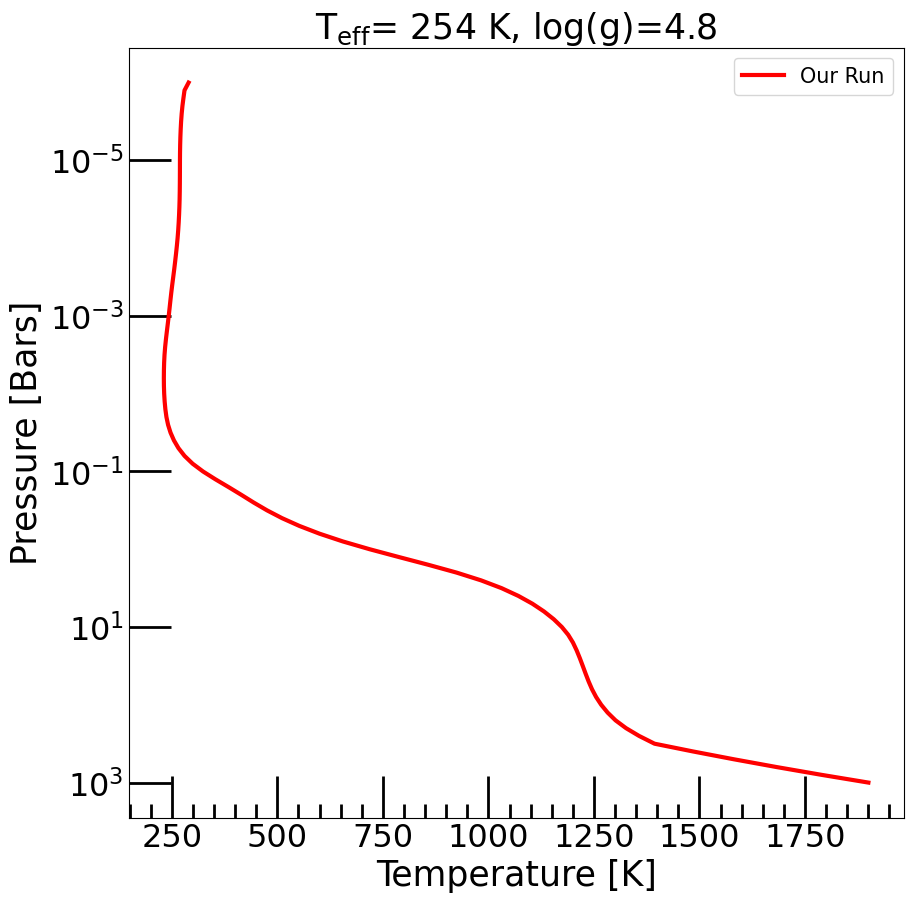

In [28]:
# Plot the PT Profile from PICASO
plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.gca().invert_yaxis()
#plt.ylim(500,1e-4)
#plt.xlim(250,1750)

plt.semilogy(out_Gstar['temperature'],out_Gstar['pressure'],color="r",linewidth=3,label="Our Run")

#plt.semilogy(base_case['temperature'],base_case['pressure'],color="k",linestyle="--",linewidth=3,label="WASP-39 b ERS Run")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 254 K, log(g)=4.8",fontsize=25)


### Apply Photochem

In [29]:
# With K218b around our Sun!

class K218b_Sun:
    planet_radius = 0.2328 # Jupiter radii
    planet_mass = 0.0272 # Jupiter masses
    planet_Teq = 278 # Equilibrium temp (K)
    stellar_radius = 1 # Solar radii
    stellar_Teff = 5778 # K
    stellar_metal = 0.0 # log10(metallicity)
    stellar_logg = 4.4 # log10(gravity), in cgs units

# Defines reaction & thermodynamic files
atoms_names=['H', 'He', 'N', 'O', 'C'] # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl), remove Sulpher for faster convergence

# Defines planet parameters
planet_mass = K218b_Sun.planet_mass*constants.M_jup.value*1e3 # grams, which is assigns a unit to the mass in Jupiter Masses, multiplyed by 10^3?
planet_radius = K218b_Sun.planet_radius*constants.R_jup.value*1e2 # cm, again which is 100x greater in radius than WASP39b but in Jupiter Radii?
solar_zenith_angle = 60 # Used in Tsai et al. (2023)
PT_list = [out_Gstar.get("pressure"), out_Gstar.get("temperature")]
metallicity = 100.0 # units of solar
CtoO = 1.0 # 1x solar
Kzz = 10**7 # cm^2/s

# Defines solar parameters
stellar_flux_file = 'Sun_Teq278'

In [30]:
sol, soleq, pc = Photochem_Gas_Giant(atoms_names=atoms_names, 
                                 stellar_flux_file=stellar_flux_file,
                                 planet_mass=planet_mass, 
                                 planet_radius=planet_radius, 
                                 solar_zenith_angle=solar_zenith_angle, 
                                 PT_list=PT_list, 
                                 metallicity=metallicity, 
                                 CtoO=CtoO,
                                 Kzz_fac=Kzz)

nsteps = 100  longdy = 9.5e-02  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 200  longdy = 8.8e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 300  longdy = 8.9e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 400  longdy = 1.9e+01  max_dT = 2.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 500  longdy = 2.1e+02  max_dT = 4.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-07
nsteps = 600  longdy = 5.9e+01  max_dT = 9.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 700  longdy = 3.0e+00  max_dT = 1.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 2.1e-07
nsteps = 800  longdy = 2.1e+01  max_dT = 3.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.9e-07
nsteps = 900  longdy = 3.0e+02  max_dT = 2.8e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 1000  longdy = 5.6e+01  max_dT = 2.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 1100  long

### Graph the Results!

In [31]:
# Plot the Composition from Photochem
fig, ax1 = plt.subplots(1,1,figsize=[5,4])
species = ['CO2','H2O','CH4','CO','NH3','H2','HCN','H2Oaer']

for i,sp in enumerate(species):
    ax1.plot(sol[sp],sol['pressure']/1e6,label=sp, c='C'+str(i))
    ax1.plot(soleq[sp],soleq['pressure']/1e6, ls=':', c='C'+str(i), alpha=0.4)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-8,1)
ax1.set_ylim(1000,1e-7)
ax1.grid(alpha=0.4)
ax1.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
ax1.set_xlabel('Mixing Ratio')
ax1.set_ylabel('Pressure (bar)')
ax1.set_yticks(10.0**np.arange(-6,2))
#ax1.text(0.02, 1.04, 't = '+'%.2e'%pc.wrk.tn, \
#    size = 15,ha='left', va='bottom',transform=ax1.transAxes)

ax2 = ax1.twiny()
ax2.set_xlabel('Temperature (K)')
ax2.plot(np.flip(PT_list[1]), np.flip(PT_list[0]), c='black', ls='--',label='PT PICASO Profile')

plt.title('K2-18b Around Sun (G-Star)')

plt.legend()

# Save the plot as a PNG image
plt.savefig('output_graph_GStar_K218b.png', bbox_inches='tight')

# Close the plot to free up memory (important if you're generating many plots)
plt.close()


## Plot of Stellar Spectra for M-Dwarf & G-Star
Just wavelength by flux!

In [32]:
Sun_stellar_flux_file = '/Users/epawelka/Documents/NASA_Ames_ProjS25/AmesProjS25Work/Sun_now.txt' # G-Star
GJ176_stellar_flux_file = 'GJ176_spectrum_278K.txt' # M-Dwarf Proxy

In [33]:
data_Sun = pd.read_csv(Sun_stellar_flux_file, sep='/t', engine='python')
data_Sun[['Wavelength (nm)', 'Solar flux (mW/m^2/nm)']] = data_Sun['Wavelength (nm)  Solar flux (mW/m^2/nm)'].str.split(expand=True)
df_Sun = data_Sun.drop('Wavelength (nm)  Solar flux (mW/m^2/nm)', axis=1)
df_Sun['Wavelength (nm)'] = df_Sun['Wavelength (nm)'].astype(float)
df_Sun['Solar flux (mW/m^2/nm)'] = df_Sun['Solar flux (mW/m^2/nm)'].astype(float)

data_MDwarf_proxy = pd.read_csv(GJ176_stellar_flux_file, sep='/t', engine='python')
data_MDwarf_proxy[['Wavelength (nm)', 'Solar flux (mW/m^2/nm)']] = data_MDwarf_proxy['Wavelength(nm)      SolarFlux(mW/m^2/nm)'].str.split(expand=True)
data_MDwarf_proxy.drop('Wavelength(nm)      SolarFlux(mW/m^2/nm)', axis=1)
data_MDwarf_proxy['Wavelength (nm)'] = data_MDwarf_proxy['Wavelength (nm)'].astype(float)
data_MDwarf_proxy['Solar flux (mW/m^2/nm)'] = data_MDwarf_proxy['Solar flux (mW/m^2/nm)'].astype(float)

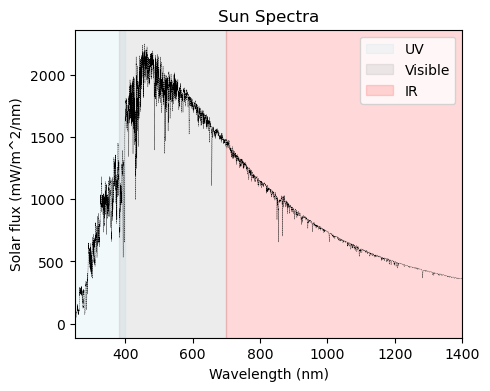

In [34]:
fig, ax1 = plt.subplots(1,1,figsize=[5,4])

ax1.plot(df_Sun['Wavelength (nm)'], df_Sun['Solar flux (mW/m^2/nm)'], color='black', ls='--', linewidth=0.25)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Solar flux (mW/m^2/nm)')
ax1.set_xlim(250,1400)

# Plot vertical lines for EM spectral boundaries (UV - IR)

# Fill the area between two vertical lines
plt.axvspan(250, 400, color='lightblue', alpha=0.15, label='UV')

# Visible
plt.axvspan(380, 700, color='grey', alpha=0.15, label='Visible')

# IR
plt.axvspan(700, 1400, color='red', alpha=0.15, label='IR')

plt.legend()
plt.title('Sun Spectra')
plt.show()

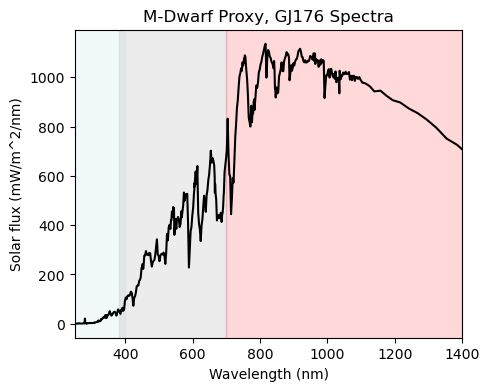

In [35]:
fig, ax = plt.subplots(1,1,figsize=[5,4])

ax.plot(data_MDwarf_proxy['Wavelength (nm)'], data_MDwarf_proxy['Solar flux (mW/m^2/nm)'], color='black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Solar flux (mW/m^2/nm)')
ax.set_xlim(250,1400)

# Fill the area between two vertical lines
plt.axvspan(250, 400, color='lightblue', alpha=0.15, label='UV')

# Visible
plt.axvspan(380, 700, color='grey', alpha=0.15, label='Visible')

# IR
plt.axvspan(700, 1400, color='red', alpha=0.15, label='IR')

plt.title('M-Dwarf Proxy, GJ176 Spectra')
plt.show()

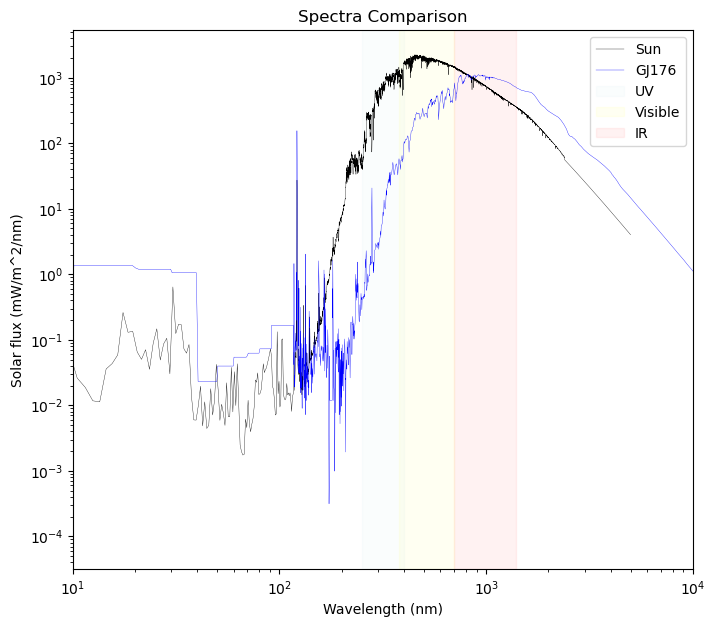

In [36]:
# Plot both on the same graph

fig, ax = plt.subplots(1,1,figsize=[8,7])

ax.plot(df_Sun['Wavelength (nm)'], df_Sun['Solar flux (mW/m^2/nm)'], color='black', ls='-', linewidth=0.25, label='Sun')
ax.plot(data_MDwarf_proxy['Wavelength (nm)'], data_MDwarf_proxy['Solar flux (mW/m^2/nm)'], linewidth=0.25, color='blue', label='GJ176')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Solar flux (mW/m^2/nm)')
ax.set_xlim(10, 10000)

# Fill the area between two vertical lines
plt.axvspan(250, 400, color='lightblue', alpha=0.05, label='UV')

# Visible
plt.axvspan(380, 700, color='yellow', alpha=0.05, label='Visible')

# IR
plt.axvspan(700, 1400, color='red', alpha=0.05, label='IR')

plt.title('Spectra Comparison')
plt.legend()
plt.show()

#### Check that the total energy is the same for MDwarf and Sun

In [37]:
np.array(data_MDwarf_proxy['Wavelength (nm)'])

array([1.00000e+00, 1.37500e+00, 2.12500e+00, ..., 8.59375e+04,
       9.53125e+04, 1.00000e+05])

In [38]:
stars.energy_in_spectrum(np.array(data_MDwarf_proxy['Wavelength (nm)']), np.array(data_MDwarf_proxy['Solar flux (mW/m^2/nm)']))

1354.7239957482307

In [39]:
stars.energy_in_spectrum(np.array(df_Sun['Wavelength (nm)']), np.array(df_Sun['Solar flux (mW/m^2/nm)']))

1374.3432238407574